In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import itertools
from lib.Curves.Curves import CurveBase
from experiments.VizReconstructionUtils import plot_cells
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.Curves.CurvePolynomial import CurveLinearAngle
from sklearn.neural_network import MLPRegressor
from experiments.LearningMethods import flatter
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from lib.DataManagers.LearningMethodManager import LearningMethodManager
import config
from lib.DataManagers.DatasetsManagers.DatasetsManagerLinearCurves import DatasetsManagerLinearCurves, ANGLE_OBJECTIVE
from lib.DataManagers.DatasetsManagers.DatasetsBaseManager import get_averages_from_curve_kernel, FLUX_PROBLEM, \
    get_flux_from_curve_and_velocity


def get_evaluations2test_curve(curve: CurveBase, kernel_size, refinement=5, center_cell_coords=None) -> np.ndarray:
    center_cell_coords = np.array(kernel_size) // 2 if center_cell_coords is None else center_cell_coords
    evaluations = np.array([curve(i - center_cell_coords[0] - 0.5, j - center_cell_coords[1] - 0.5) for i, j in
                            itertools.product(*list(map(lambda s: np.linspace(0, s, num=s * refinement, endpoint=False),
                                                        kernel_size)))]).reshape(
        tuple(np.array(kernel_size) * refinement))
    return evaluations


N = int(1e6)
dataset_manager_3_8pi = DatasetsManagerLinearCurves(
    velocity_range=[(0, 1 / 4), (1 / 4, 0)], path2data=config.data_path, N=N, kernel_size=(3, 3), min_val=0, max_val=1,
    workers=15, recalculate=True, learning_objective=ANGLE_OBJECTIVE, angle_limits=(-3 / 8, 3 / 8),
    value_up_random=True
)

nnlm = LearningMethodManager(
    dataset_manager=dataset_manager_3_8pi,
    type_of_problem=FLUX_PROBLEM,
    trainable_model=Pipeline(
        [
            ("Flatter", FunctionTransformer(flatter)),
            ("NN", MLPRegressor(hidden_layer_sizes=(20, 20,), activation='relu', learning_rate_init=0.1,
                                learning_rate="adaptive", solver="adam"))
        ]
    ),
    refit=True, n2use=-1,
    training_noise=1e-5, train_percentage=0.9
)




Generating data for Dataset4Learning_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1Generating data CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1...


Creating dataset.: 0it [00:00, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

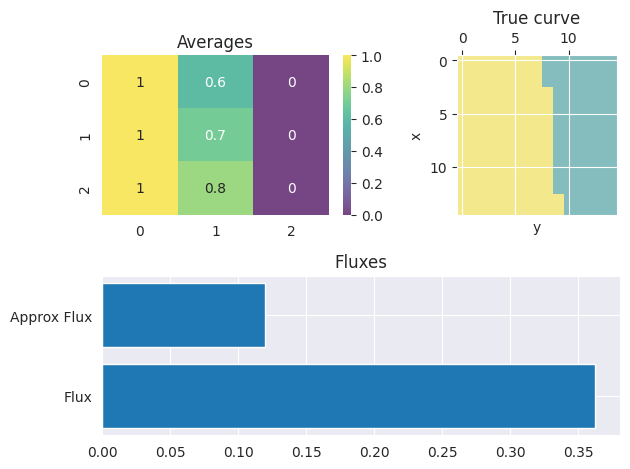

In [33]:

kernel_size = (3, 3)
angle = 0.1
y0 = 0.2
velocity = (0.5, 0)
value_up = 0
value_down = 1
refinement = 5

curve = CurveLinearAngle(angle, y0, value_up, value_down, x_shift=0)
kernel = get_averages_from_curve_kernel(kernel_size, curve, center_cell_coords=None)
u = get_evaluations2test_curve(curve, kernel_size, refinement=refinement)
flux = get_flux_from_curve_and_velocity(curve, center_cell_coords=np.array(kernel_size) // 2, velocity=velocity)[0]
_, pred_flux = nnlm.predict_flux(kernel, velocity)

fig = plt.figure()
ax = fig.add_gridspec(6, 5)
ax1 = fig.add_subplot(ax[:3, 0:3])
ax1.set_title('Averages')
ax2 = fig.add_subplot(ax[:3, 3:])
ax2.set_title('True curve')
ax3 = fig.add_subplot(ax[3:, :])
ax3.set_title('Fluxes')

sns.heatmap(kernel, annot=True, cmap="viridis", alpha=0.7, ax=ax1)
plot_cells(ax=ax2, colors=u, mesh_shape=np.array(kernel_size) * refinement, alpha=0.5,
           cmap="viridis",
           vmin=-1, vmax=1)
ax3.barh(["Flux", "Approx Flux"], [flux, pred_flux])
plt.tight_layout()